# Predicting S&P 500 Returns Using Fed Probabilities

This notebook trains XGBoost models to predict next-day S&P 500 returns based on Fed event probabilities.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Load the merged dataset
df = pd.read_csv("../data/sp500_fed_ml_ready_with_targets.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total rows: {len(df)}")


Dataset shape: (205, 110)
Date range: 2024-12-30 00:00:00 to 2025-10-23 00:00:00
Total rows: 205


In [3]:
# IMPORTANT: Fed probabilities are available at 00:00 (midnight)
# Market opens at 14:30 (2:30 PM) on the same day
# So we should predict INTRADAY return (Open to Close) on the SAME day
# Strategy: Use Fed probabilities from day T (00:00) to predict return from day T's Open to Close
#
# DATA LEAKAGE FIX: We ONLY use Fed probability features (no S&P 500 features)
# At market open on day T, we only know:
#   - Fed probabilities from day T (00:00) ✓ - CAN USE (available before market open)
#   - NOT same-day S&P data (Close_T, High_T, Low_T, Daily_Return_T, etc.) ✗ - CANNOT USE
#   - NOT previous day's S&P returns as features ✗ - EXCLUDED to avoid any leakage
#
# For rolling window: Uses temporal splits (train on past, test on future)
# Model naturally learns from previous days' Fed data patterns

print("=== TARGET VARIABLE: INTRADAY RETURN (Open to Close) ===")
print("Timing:")
print("  - Fed probabilities available: 00:00 (midnight) on day T")
print("  - Market opens: 14:30 (2:30 PM) on day T")
print("  - Market closes: 21:00 (9:00 PM) on day T")
print("  - Strategy: Buy at open, sell at close on same day\n")

# Calculate intraday return: (Close - Open) / Open
df['intraday_return'] = (df['Close'] - df['Open']) / df['Open']

# Alternative: Use Open_Close_Range which is already calculated
# But let's use our calculated one for clarity
if 'Open_Close_Range' in df.columns:
    print(f"Open_Close_Range stats: mean={df['Open_Close_Range'].mean():.6f}, std={df['Open_Close_Range'].std():.6f}")
    print(f"Calculated intraday_return stats: mean={df['intraday_return'].mean():.6f}, std={df['intraday_return'].std():.6f}")
    # Use the calculated one
    df['target_intraday_return'] = df['intraday_return']
else:
    df['target_intraday_return'] = df['intraday_return']

print(f"\nIntraday return stats:")
print(f"  Mean: {df['target_intraday_return'].mean():.6f}")
print(f"  Std: {df['target_intraday_return'].std():.6f}")
print(f"  Min: {df['target_intraday_return'].min():.6f}")
print(f"  Max: {df['target_intraday_return'].max():.6f}")

# Identify feature columns - ONLY USE FED FEATURES
# CRITICAL: We do NOT use S&P 500 features (High, Low, Close, Daily_Return, etc.) 
# because they cause data leakage - we can't know same-day S&P data at market open
fed_feature_cols = [col for col in df.columns if col.startswith('Fed_') or 'How_many' in col or 'Jerome' in col or 'Who_will' in col]

# Use ONLY Fed features (no S&P 500 features at all)
feature_cols = fed_feature_cols

# Remove any columns that don't exist
feature_cols = [col for col in feature_cols if col in df.columns]

print(f"\nTotal features: {len(feature_cols)}")
print(f"  - Fed features: {len(fed_feature_cols)}")
print(f"  - S&P 500 features: 0 (excluded to prevent data leakage)")
print(f"\n✓ Using ONLY Fed probability features")
print(f"✓ No S&P 500 data (High, Low, Close, Daily_Return, etc.) used as features")

# Prepare features and target
X = df[feature_cols].copy()
y = df['target_intraday_return'].copy()  # Changed to intraday return

# Remove rows with NaN targets
valid_idx = ~y.isna()
X = X[valid_idx].copy()
y = y[valid_idx].copy()
dates = df.loc[valid_idx, 'Date'].copy()

# Fill any remaining NaN with 0
X = X.fillna(0)

print(f"\nAfter removing NaN targets:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Target stats: mean={y.mean():.4f}, std={y.std():.4f}")
print(f"\n✓ Target: Intraday return (Open to Close) on same day")
print(f"✓ Strategy: Use Fed probabilities from 00:00 to predict same-day open-to-close return")


=== TARGET VARIABLE: INTRADAY RETURN (Open to Close) ===
Timing:
  - Fed probabilities available: 00:00 (midnight) on day T
  - Market opens: 14:30 (2:30 PM) on day T
  - Market closes: 21:00 (9:00 PM) on day T
  - Strategy: Buy at open, sell at close on same day

Open_Close_Range stats: mean=0.006490, std=0.008448
Calculated intraday_return stats: mean=0.000455, std=0.010961

Intraday return stats:
  Mean: 0.000455
  Std: 0.010961
  Min: -0.041205
  Max: 0.099012

Total features: 88
  - Fed features: 88
  - S&P 500 features: 0 (excluded to prevent data leakage)

✓ Using ONLY Fed probability features
✓ No S&P 500 data (High, Low, Close, Daily_Return, etc.) used as features

After removing NaN targets:
  X shape: (205, 88)
  y shape: (205,)
  Target stats: mean=0.0005, std=0.0110

✓ Target: Intraday return (Open to Close) on same day
✓ Strategy: Use Fed probabilities from 00:00 to predict same-day open-to-close return


## Approach 1: 80/20 Train-Test Split


In [4]:
# 80/20 split (shuffle=False to maintain temporal order)
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, shuffle=False, random_state=42
)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Date range: {dates_train.min()} to {dates_train.max()}")
print(f"\nTest set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Date range: {dates_test.min()} to {dates_test.max()}")


Training set: 164 samples (80.0%)
  Date range: 2024-12-30 00:00:00 to 2025-08-26 00:00:00

Test set: 41 samples (20.0%)
  Date range: 2025-08-27 00:00:00 to 2025-10-23 00:00:00


In [5]:
# DIAGNOSIS: With only ~205 rows and ~100+ features, we have severe overfitting risk
# The target is: target_intraday_return (same day's Open to Close return)
print(f"\n⚠️  DATA SIZE WARNING:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Features: {len(feature_cols)}")
print(f"  Ratio: {len(X_train)/len(feature_cols):.2f} samples per feature")
print(f"  Target: target_intraday_return (same day Open to Close return)")
print(f"  Strategy: Buy at open, sell at close on same day")
print(f"\n  Recommendation: Need at least 10-20 samples per feature for stable models")
print(f"  Current: {len(X_train)/len(feature_cols):.2f} samples per feature")

# Feature selection to reduce overfitting
print("\n=== FEATURE SELECTION ===")
from sklearn.feature_selection import SelectKBest, f_regression

# Select top features based on correlation with target
selector = SelectKBest(f_regression, k=min(20, len(feature_cols)))  # Top 20 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
print(f"Selected {len(selected_features)} most important features")
print(f"Top 10: {selected_features[:10]}")

# Train XGBoost model with REGULARIZATION (to prevent overfitting)
print("\nTraining XGBoost model with regularization...")

model_80_20 = xgb.XGBRegressor(
    n_estimators=100,  # Reduced from 200
    max_depth=3,       # Reduced from 6 (shallower trees)
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,      # L1 regularization
    reg_lambda=1.0,     # L2 regularization
    min_child_weight=3, # Minimum samples per leaf
    random_state=42,
    n_jobs=-1
)

# Train on selected features
model_80_20.fit(X_train_selected, y_train)

# Predictions (store with specific names to avoid conflicts)
y_train_pred_80_20 = model_80_20.predict(X_train_selected)
y_test_pred_80_20 = model_80_20.predict(X_test_selected)

# Evaluate
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_80_20))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_80_20))
train_mae = mean_absolute_error(y_train, y_train_pred_80_20)
test_mae = mean_absolute_error(y_test, y_test_pred_80_20)
train_r2 = r2_score(y_train, y_train_pred_80_20)
test_r2 = r2_score(y_test, y_test_pred_80_20)

print("\n=== Model Performance (80/20 Split with Feature Selection) ===")
print(f"Training RMSE: {train_rmse:.6f}")
print(f"Test RMSE: {test_rmse:.6f}")
print(f"Training MAE: {train_mae:.6f}")
print(f"Test MAE: {test_mae:.6f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

if test_r2 < 0:
    print("\n⚠️  WARNING: Negative R² means model performs worse than predicting the mean!")
    print("   This indicates severe overfitting or insufficient data.")



⚠️  DATA SIZE WARNING:
  Training samples: 164
  Test samples: 41
  Features: 88
  Ratio: 1.86 samples per feature
  Target: target_intraday_return (same day Open to Close return)
  Strategy: Buy at open, sell at close on same day

  Recommendation: Need at least 10-20 samples per feature for stable models
  Current: 1.86 samples per feature

=== FEATURE SELECTION ===
Selected 20 most important features
Top 10: ['Fed_emergency_rate_cut_in_2025_Price', 'How_many_Fed_rate_cuts_in_2025_1_25_bps', 'How_many_Fed_rate_cuts_in_2025_2_50_bps', 'How_many_Fed_rate_cuts_in_2025_4_100_bps', 'How_many_Fed_rate_cuts_in_2025_5_125_bps', 'How_many_Fed_rate_cuts_in_2025_6_150_bps', 'How_many_Fed_rate_cuts_in_2025_7_175_bps', 'How_many_Fed_rate_cuts_in_2025_8_or_more_200_bps', 'Who_will_Trump_announce_as_next_Fed_Chair_in_2025_Arthur_Laffer', 'Who_will_Trump_announce_as_next_Fed_Chair_in_2025_Chamath_Palihapitiya']

Training XGBoost model with regularization...

=== Model Performance (80/20 Split with 


=== Most Important Features (Selected) ===
                                              feature  importance
12  Who_will_Trump_announce_as_next_Fed_Chair_in_2...    0.136250
1             How_many_Fed_rate_cuts_in_2025_1_25_bps    0.089277
5            How_many_Fed_rate_cuts_in_2025_6_150_bps    0.077689
16  Who_will_Trump_announce_as_next_Fed_Chair_in_2...    0.077229
0                Fed_emergency_rate_cut_in_2025_Price    0.076432
7    How_many_Fed_rate_cuts_in_2025_8_or_more_200_bps    0.074520
14  Who_will_Trump_announce_as_next_Fed_Chair_in_2...    0.072120
6            How_many_Fed_rate_cuts_in_2025_7_175_bps    0.065727
8   Who_will_Trump_announce_as_next_Fed_Chair_in_2...    0.051836
9   Who_will_Trump_announce_as_next_Fed_Chair_in_2...    0.045462
4            How_many_Fed_rate_cuts_in_2025_5_125_bps    0.043953
17  Who_will_Trump_nominate_as_Fed_Chair_Jerome_Po...    0.042077
13  Who_will_Trump_announce_as_next_Fed_Chair_in_2...    0.037199
3            How_many_Fed_rate_c

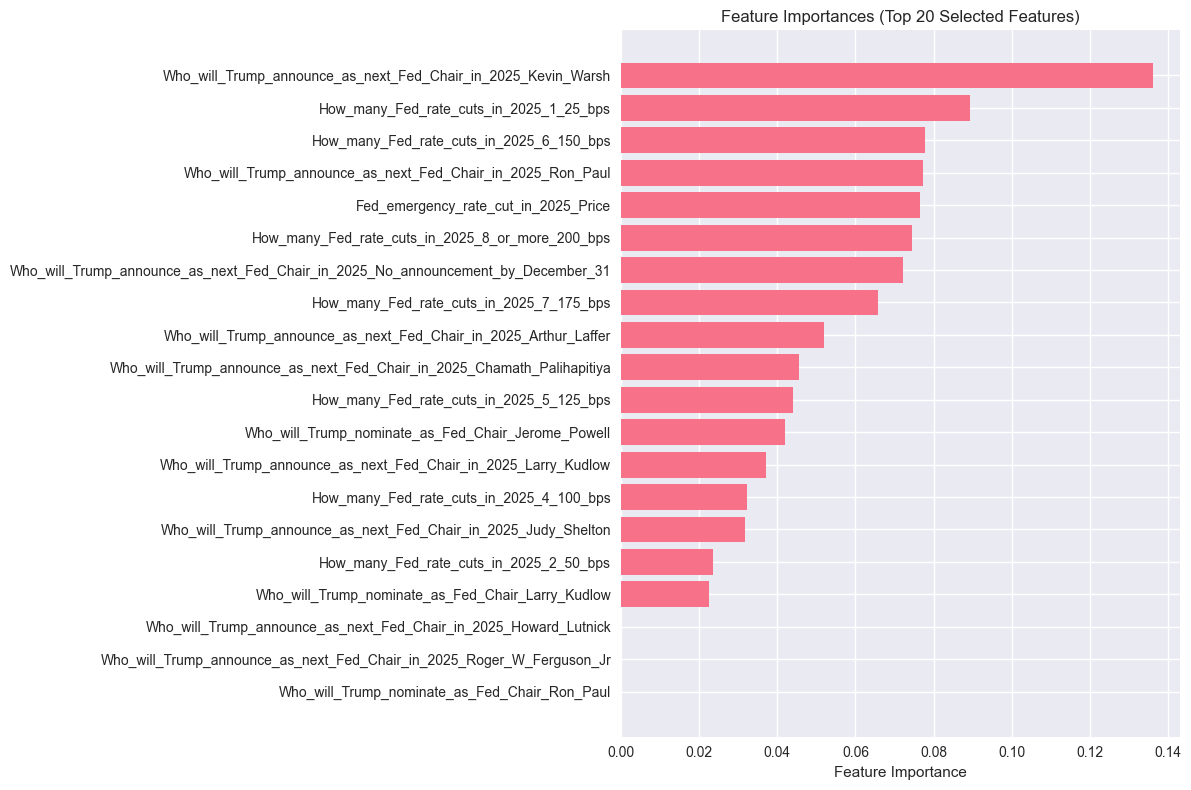

In [6]:
# Feature importance (for selected features)
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': model_80_20.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Most Important Features (Selected) ===")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title(f'Feature Importances (Top {len(selected_features)} Selected Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


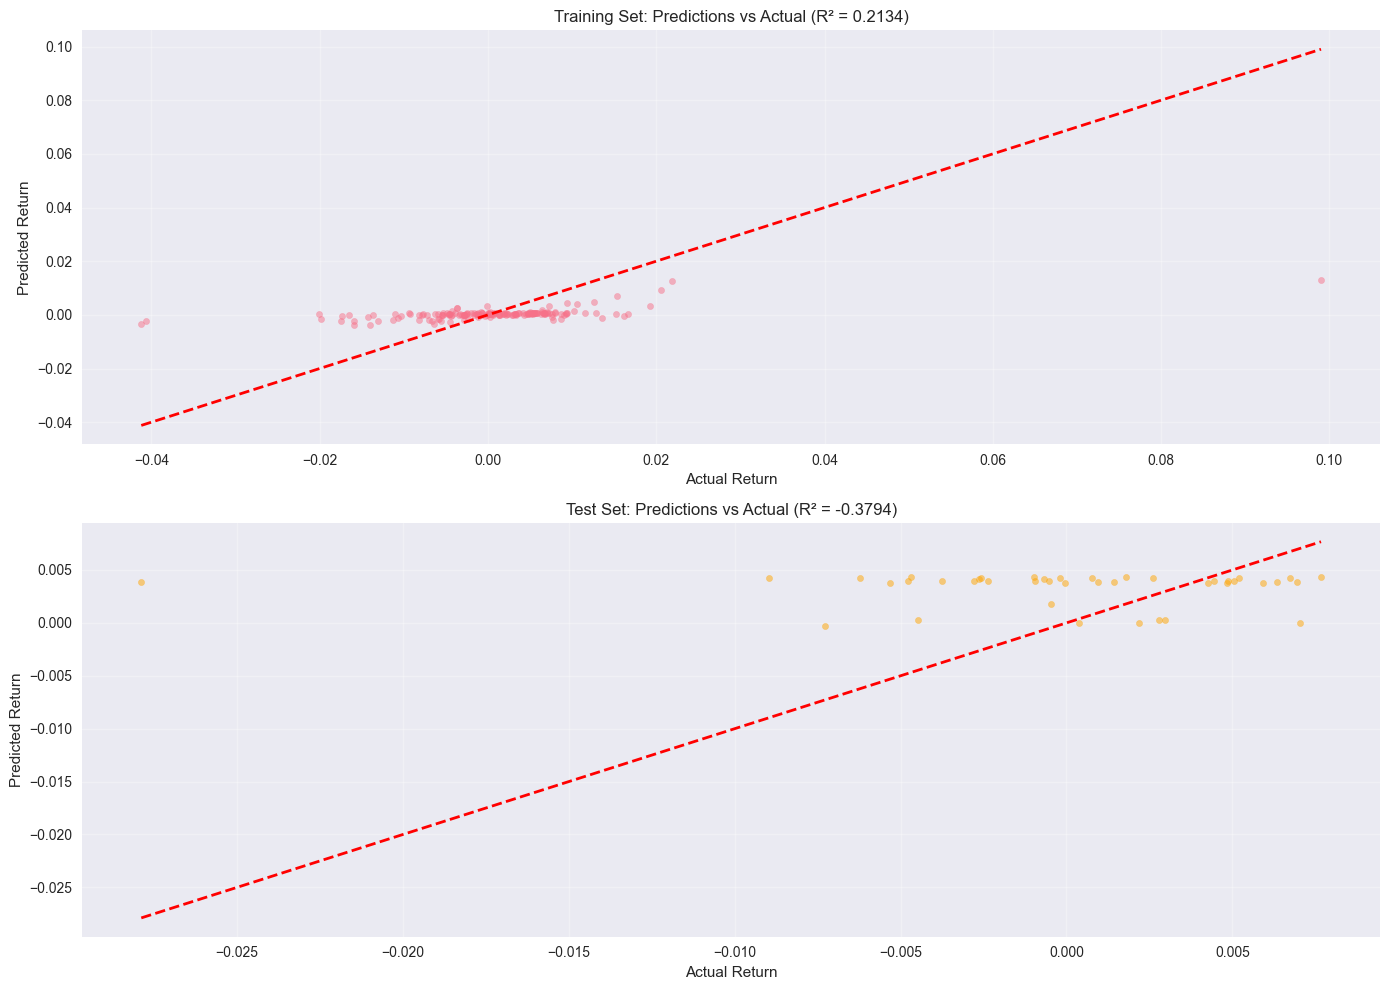

In [7]:
# Plot predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Training set
axes[0].scatter(y_train, y_train_pred_80_20, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Return')
axes[0].set_ylabel('Predicted Return')
axes[0].set_title(f'Training Set: Predictions vs Actual (R² = {train_r2:.4f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_80_20, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Return')
axes[1].set_ylabel('Predicted Return')
axes[1].set_title(f'Test Set: Predictions vs Actual (R² = {test_r2:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


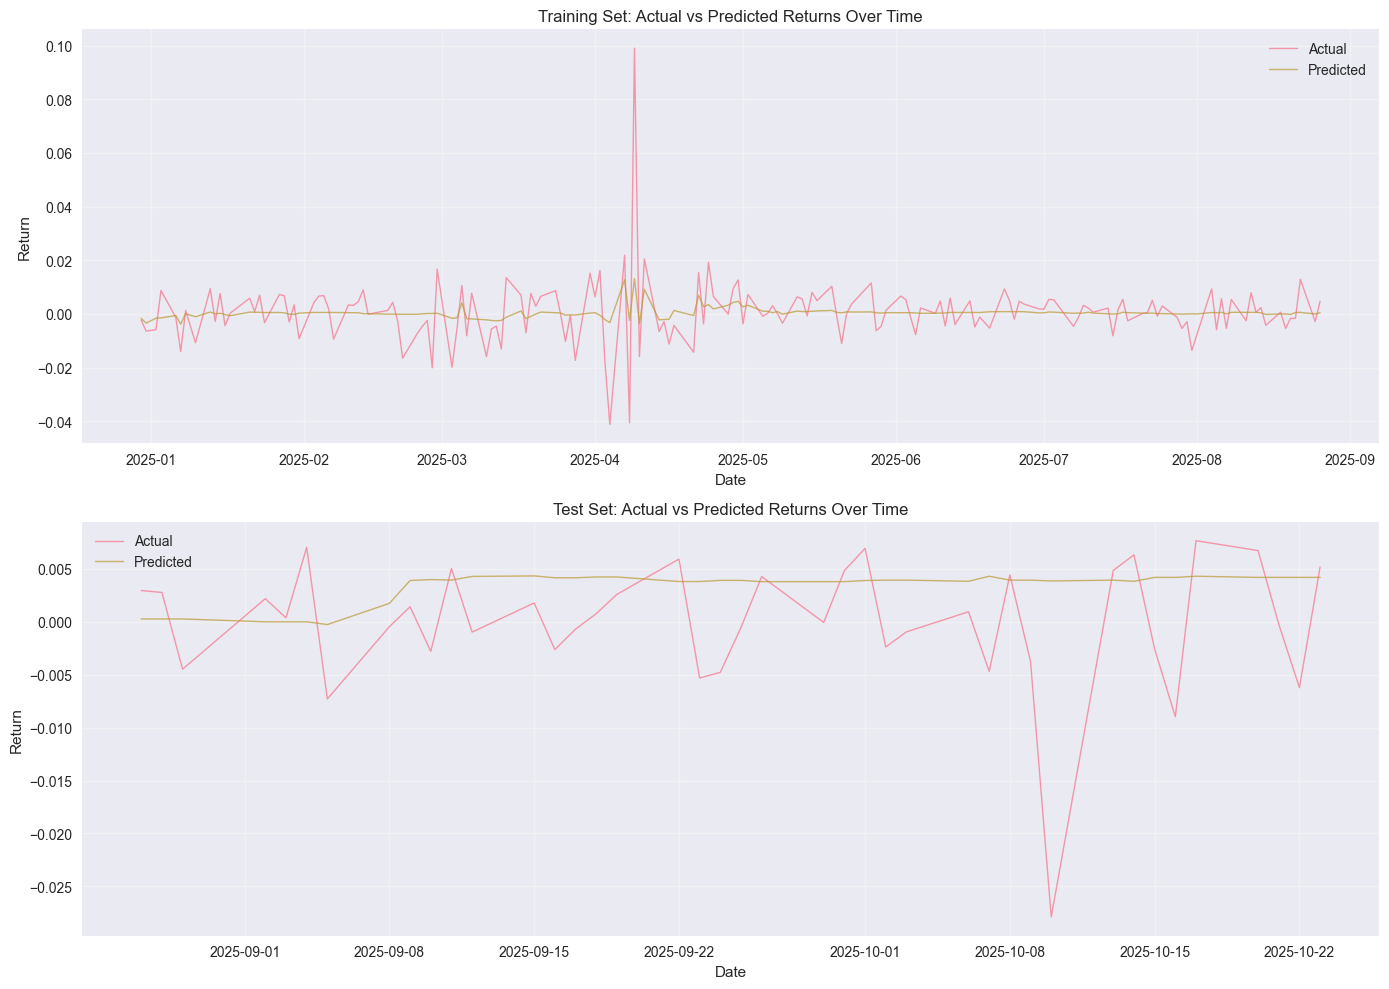

In [8]:
# Time series plot of predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Training set
train_df = pd.DataFrame({
    'Date': dates_train.values,
    'Actual': y_train.values,
    'Predicted': y_train_pred_80_20
}).sort_values('Date')

axes[0].plot(train_df['Date'], train_df['Actual'], label='Actual', alpha=0.7, linewidth=1)
axes[0].plot(train_df['Date'], train_df['Predicted'], label='Predicted', alpha=0.7, linewidth=1)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Return')
axes[0].set_title('Training Set: Actual vs Predicted Returns Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
test_df = pd.DataFrame({
    'Date': dates_test.values,
    'Actual': y_test.values,
    'Predicted': y_test_pred_80_20
}).sort_values('Date')

axes[1].plot(test_df['Date'], test_df['Actual'], label='Actual', alpha=0.7, linewidth=1)
axes[1].plot(test_df['Date'], test_df['Predicted'], label='Predicted', alpha=0.7, linewidth=1)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Return')
axes[1].set_title('Test Set: Actual vs Predicted Returns Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Approach 2: Rolling Window (Time Series Cross-Validation)


In [9]:
# Rolling window approach
# Train on first N% of data, test on next chunk, then roll forward

def rolling_window_train_test(X, y, dates, train_size=0.7, step_size=0.1):
    """
    Create rolling window train/test splits
    
    Parameters:
    - train_size: proportion of data to use for training in each window
    - step_size: proportion to step forward for next window
    """
    n = len(X)
    train_len = int(n * train_size)
    step_len = int(n * step_size)
    
    splits = []
    start_idx = 0
    
    while start_idx + train_len < n:
        train_end = start_idx + train_len
        test_end = min(train_end + step_len, n)
        
        X_train = X.iloc[start_idx:train_end]
        y_train = y.iloc[start_idx:train_end]
        dates_train = dates.iloc[start_idx:train_end]
        
        X_test = X.iloc[train_end:test_end]
        y_test = y.iloc[train_end:test_end]
        dates_test = dates.iloc[train_end:test_end]
        
        splits.append({
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            'dates_train': dates_train,
            'dates_test': dates_test,
            'train_start': start_idx,
            'train_end': train_end,
            'test_start': train_end,
            'test_end': test_end
        })
        
        start_idx += step_len
    
    return splits

# Create rolling windows
splits = rolling_window_train_test(X, y, dates, train_size=0.7, step_size=0.1)
print(f"Created {len(splits)} rolling window splits")
print(f"\nFirst split:")
print(f"  Train: {splits[0]['train_start']} to {splits[0]['train_end']} ({len(splits[0]['X_train'])} samples)")
print(f"  Test: {splits[0]['test_start']} to {splits[0]['test_end']} ({len(splits[0]['X_test'])} samples)")
print(f"\nLast split:")
print(f"  Train: {splits[-1]['train_start']} to {splits[-1]['train_end']} ({len(splits[-1]['X_train'])} samples)")
print(f"  Test: {splits[-1]['test_start']} to {splits[-1]['test_end']} ({len(splits[-1]['X_test'])} samples)")


Created 4 rolling window splits

First split:
  Train: 0 to 143 (143 samples)
  Test: 143 to 163 (20 samples)

Last split:
  Train: 60 to 203 (143 samples)
  Test: 203 to 205 (2 samples)


In [10]:
# Train models on each rolling window with feature selection
rolling_results = []

for i, split in enumerate(splits):
    print(f"\nTraining model {i+1}/{len(splits)}...")
    
    # Feature selection for this window
    from sklearn.feature_selection import SelectKBest, f_regression
    selector_window = SelectKBest(f_regression, k=min(20, len(feature_cols)))
    X_train_window = selector_window.fit_transform(split['X_train'], split['y_train'])
    X_test_window = selector_window.transform(split['X_test'])
    
    # Train model with regularization
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        min_child_weight=3,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_window, split['y_train'])
    
    # Predictions
    y_train_pred = model.predict(X_train_window)
    y_test_pred = model.predict(X_test_window)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(split['y_train'], y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(split['y_test'], y_test_pred))
    train_r2 = r2_score(split['y_train'], y_train_pred)
    test_r2 = r2_score(split['y_test'], y_test_pred)
    
    rolling_results.append({
        'window': i+1,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_size': len(split['X_train']),
        'test_size': len(split['X_test']),
        'test_start_date': split['dates_test'].min(),
        'test_end_date': split['dates_test'].max(),
        'predictions': y_test_pred,
        'actuals': split['y_test'].values,
        'dates': split['dates_test'].values
    })

results_df = pd.DataFrame(rolling_results)
print("\n=== Rolling Window Results Summary ===")
print(results_df[['window', 'train_rmse', 'test_rmse', 'train_r2', 'test_r2']].describe())



Training model 1/4...

Training model 2/4...

Training model 3/4...

Training model 4/4...

=== Rolling Window Results Summary ===
         window  train_rmse  test_rmse  train_r2   test_r2
count  4.000000    4.000000   4.000000  4.000000  4.000000
mean   2.500000    0.010908   0.005963  0.204877 -0.064285
std    1.290994    0.000181   0.001492  0.015235  0.170267
min    1.000000    0.010641   0.004237  0.184505 -0.302524
25%    1.750000    0.010889   0.005129  0.198760 -0.115615
50%    2.500000    0.010976   0.005934  0.207306 -0.025084
75%    3.250000    0.010995   0.006768  0.213422  0.026246
max    4.000000    0.011038   0.007748  0.220392  0.095551


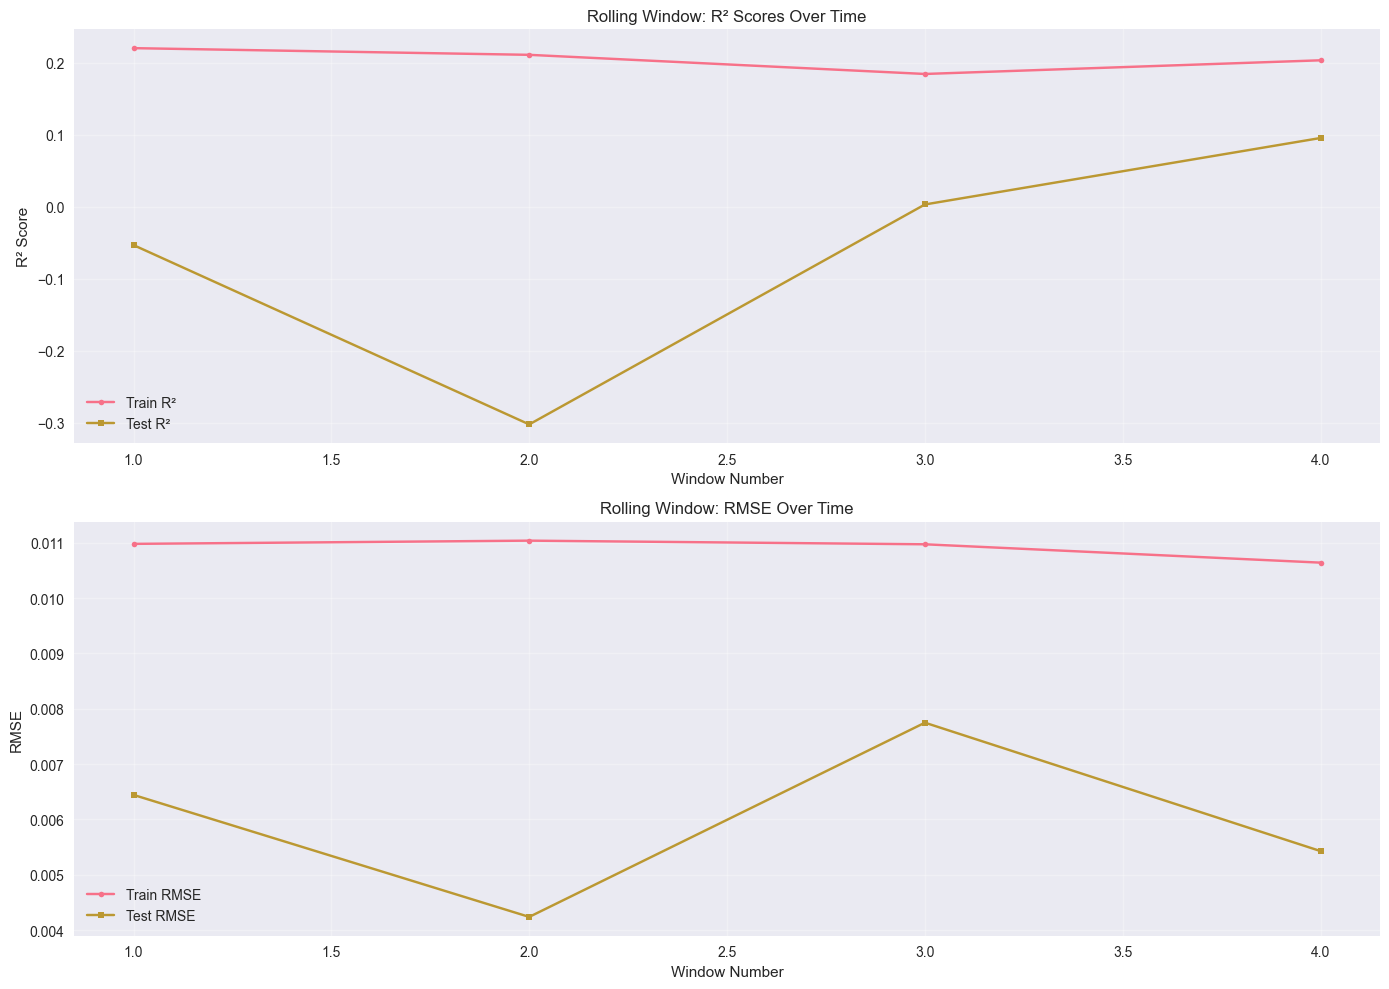

In [11]:
# Plot rolling window performance over time
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# R² scores
axes[0].plot(results_df['window'], results_df['train_r2'], label='Train R²', marker='o', markersize=4)
axes[0].plot(results_df['window'], results_df['test_r2'], label='Test R²', marker='s', markersize=4)
axes[0].set_xlabel('Window Number')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Rolling Window: R² Scores Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].plot(results_df['window'], results_df['train_rmse'], label='Train RMSE', marker='o', markersize=4)
axes[1].plot(results_df['window'], results_df['test_rmse'], label='Test RMSE', marker='s', markersize=4)
axes[1].set_xlabel('Window Number')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Rolling Window: RMSE Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== Overall Rolling Window Performance ===
RMSE: 0.006284
MAE: 0.004719
R²: -0.0396


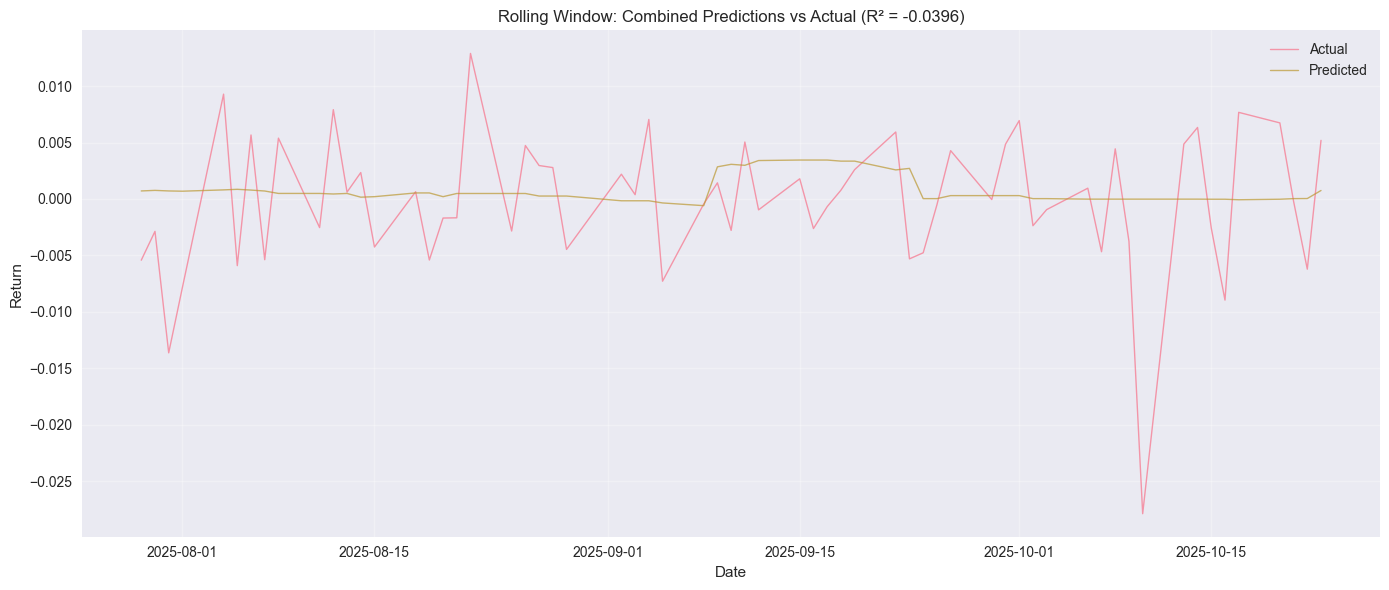

In [12]:
# Combine all predictions from rolling windows
all_predictions = []
all_actuals = []
all_dates = []

for result in rolling_results:
    all_predictions.extend(result['predictions'])
    all_actuals.extend(result['actuals'])
    all_dates.extend(result['dates'])

# Create combined dataframe
combined_df = pd.DataFrame({
    'Date': pd.to_datetime(all_dates),
    'Actual': all_actuals,
    'Predicted': all_predictions
}).sort_values('Date').reset_index(drop=True)

# Calculate overall metrics
overall_rmse = np.sqrt(mean_squared_error(combined_df['Actual'], combined_df['Predicted']))
overall_mae = mean_absolute_error(combined_df['Actual'], combined_df['Predicted'])
overall_r2 = r2_score(combined_df['Actual'], combined_df['Predicted'])

print("=== Overall Rolling Window Performance ===")
print(f"RMSE: {overall_rmse:.6f}")
print(f"MAE: {overall_mae:.6f}")
print(f"R²: {overall_r2:.4f}")

# Plot combined predictions
plt.figure(figsize=(14, 6))
plt.plot(combined_df['Date'], combined_df['Actual'], label='Actual', alpha=0.7, linewidth=1)
plt.plot(combined_df['Date'], combined_df['Predicted'], label='Predicted', alpha=0.7, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Return')
plt.title(f'Rolling Window: Combined Predictions vs Actual (R² = {overall_r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Comparison: 80/20 vs Rolling Window


=== Model Comparison ===
         Approach  Test RMSE  Test MAE   Test R²
0     80/20 Split   0.005426  0.004990  0.095551
1  Rolling Window   0.006284  0.004719 -0.039594


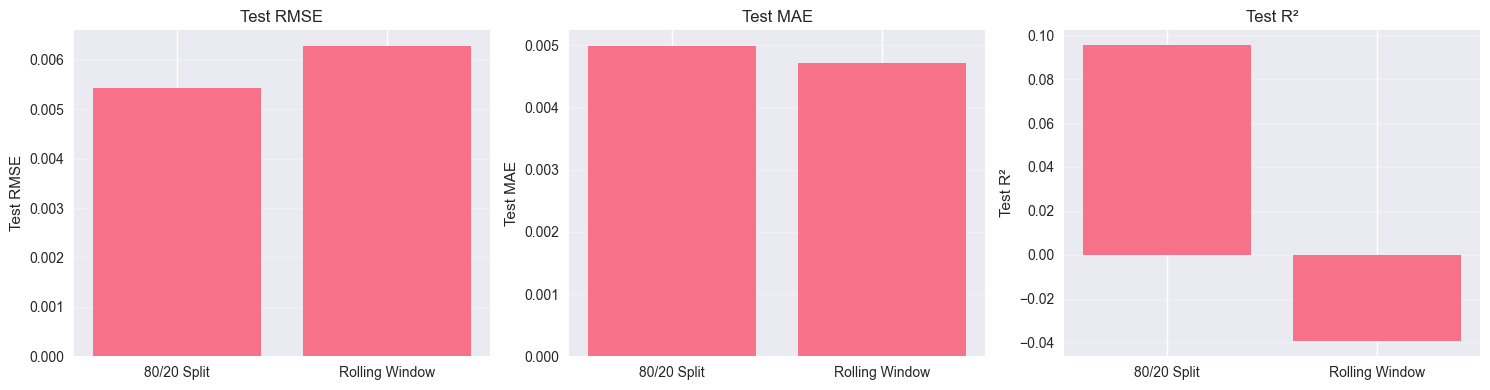

In [13]:
# Compare approaches
comparison = pd.DataFrame({
    'Approach': ['80/20 Split', 'Rolling Window'],
    'Test RMSE': [test_rmse, overall_rmse],
    'Test MAE': [test_mae, overall_mae],
    'Test R²': [test_r2, overall_r2]
})

print("=== Model Comparison ===")
print(comparison)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['Test RMSE', 'Test MAE', 'Test R²']
for i, metric in enumerate(metrics):
    axes[i].bar(comparison['Approach'], comparison[metric])
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Trading Strategy Backtest


In [14]:
# Trading strategy: Buy at open, sell at close on same day
def backtest_strategy(actual_returns, predicted_returns, threshold=0.0):
    """
    Strategy: 
    - Use Fed probabilities from 00:00 (midnight) on day T
    - Predict intraday return (Open to Close) on day T
    - If predicted return > threshold: Buy at open, sell at close
    - Else: Hold cash (no position)
    """
    signals = (predicted_returns > threshold).astype(int)
    strategy_returns = signals * actual_returns
    
    cumulative_returns = (1 + strategy_returns).cumprod()
    buy_hold_returns = (1 + actual_returns).cumprod()
    
    total_return = cumulative_returns.iloc[-1] - 1
    buy_hold_return = buy_hold_returns.iloc[-1] - 1
 
    # Annualized Sharpe ratio with 4% risk-free rate (assuming ~252 trading days)
    risk_free_rate_annual = 0.04  # 4% annual risk-free rate
    annual_return = strategy_returns.mean() * 252
    annual_vol = strategy_returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate_annual) / annual_vol if annual_vol > 0 else 0
    
    # Calculate additional metrics
    num_trades = signals.sum()
    win_rate = (strategy_returns[signals == 1] > 0).mean() if num_trades > 0 else 0
    avg_return_per_trade = strategy_returns[signals == 1].mean() if num_trades > 0 else 0
    
    return {
        'signals': signals,
        'strategy_returns': strategy_returns,
        'cumulative_returns': cumulative_returns,
        'buy_hold_returns': buy_hold_returns,
        'total_return': total_return,
        'buy_hold_return': buy_hold_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate,
        'num_trades': num_trades,
        'avg_return_per_trade': avg_return_per_trade
    }

# Backtest on 80/20 test set
# Make sure we use the correct predictions from 80/20 split
test_returns = pd.Series(y_test.values, index=dates_test.values)
test_preds = pd.Series(y_test_pred_80_20, index=dates_test.values)

strategy_80_20 = backtest_strategy(test_returns, test_preds, threshold=0.0)

print("=== Trading Strategy Performance (80/20 Test Set) ===")
print(f"Strategy: Buy at open, sell at close on same day")
print(f"Strategy Total Return: {strategy_80_20['total_return']*100:.2f}%")
print(f"Buy & Hold Return: {strategy_80_20['buy_hold_return']*100:.2f}%")
print(f"Sharpe Ratio: {strategy_80_20['sharpe_ratio']:.4f}")
print(f"Number of Trades: {strategy_80_20['num_trades']}")
print(f"Win Rate: {strategy_80_20['win_rate']*100:.2f}%")
print(f"Avg Return per Trade: {strategy_80_20['avg_return_per_trade']*100:.4f}%")

# Backtest on rolling window predictions
rolling_returns = pd.Series(combined_df['Actual'].values, index=combined_df['Date'])
rolling_preds = pd.Series(combined_df['Predicted'].values, index=combined_df['Date'])

strategy_rolling = backtest_strategy(rolling_returns, rolling_preds, threshold=0.0)

print("\n=== Trading Strategy Performance (Rolling Window) ===")
print(f"Strategy: Buy at open, sell at close on same day")
print(f"Strategy Total Return: {strategy_rolling['total_return']*100:.2f}%")
print(f"Buy & Hold Return: {strategy_rolling['buy_hold_return']*100:.2f}%")
print(f"Sharpe Ratio: {strategy_rolling['sharpe_ratio']:.4f}")
print(f"Number of Trades: {strategy_rolling['num_trades']}")
print(f"Win Rate: {strategy_rolling['win_rate']*100:.2f}%")
print(f"Avg Return per Trade: {strategy_rolling['avg_return_per_trade']*100:.4f}%")


=== Trading Strategy Performance (80/20 Test Set) ===
Strategy: Buy at open, sell at close on same day
Strategy Total Return: 0.42%
Buy & Hold Return: -0.31%
Sharpe Ratio: -0.1006
Number of Trades: 40
Win Rate: 52.50%
Avg Return per Trade: 0.0123%

=== Trading Strategy Performance (Rolling Window) ===
Strategy: Buy at open, sell at close on same day
Strategy Total Return: 0.20%
Buy & Hold Return: -1.35%
Sharpe Ratio: -0.4247
Number of Trades: 46
Win Rate: 45.65%
Avg Return per Trade: 0.0057%


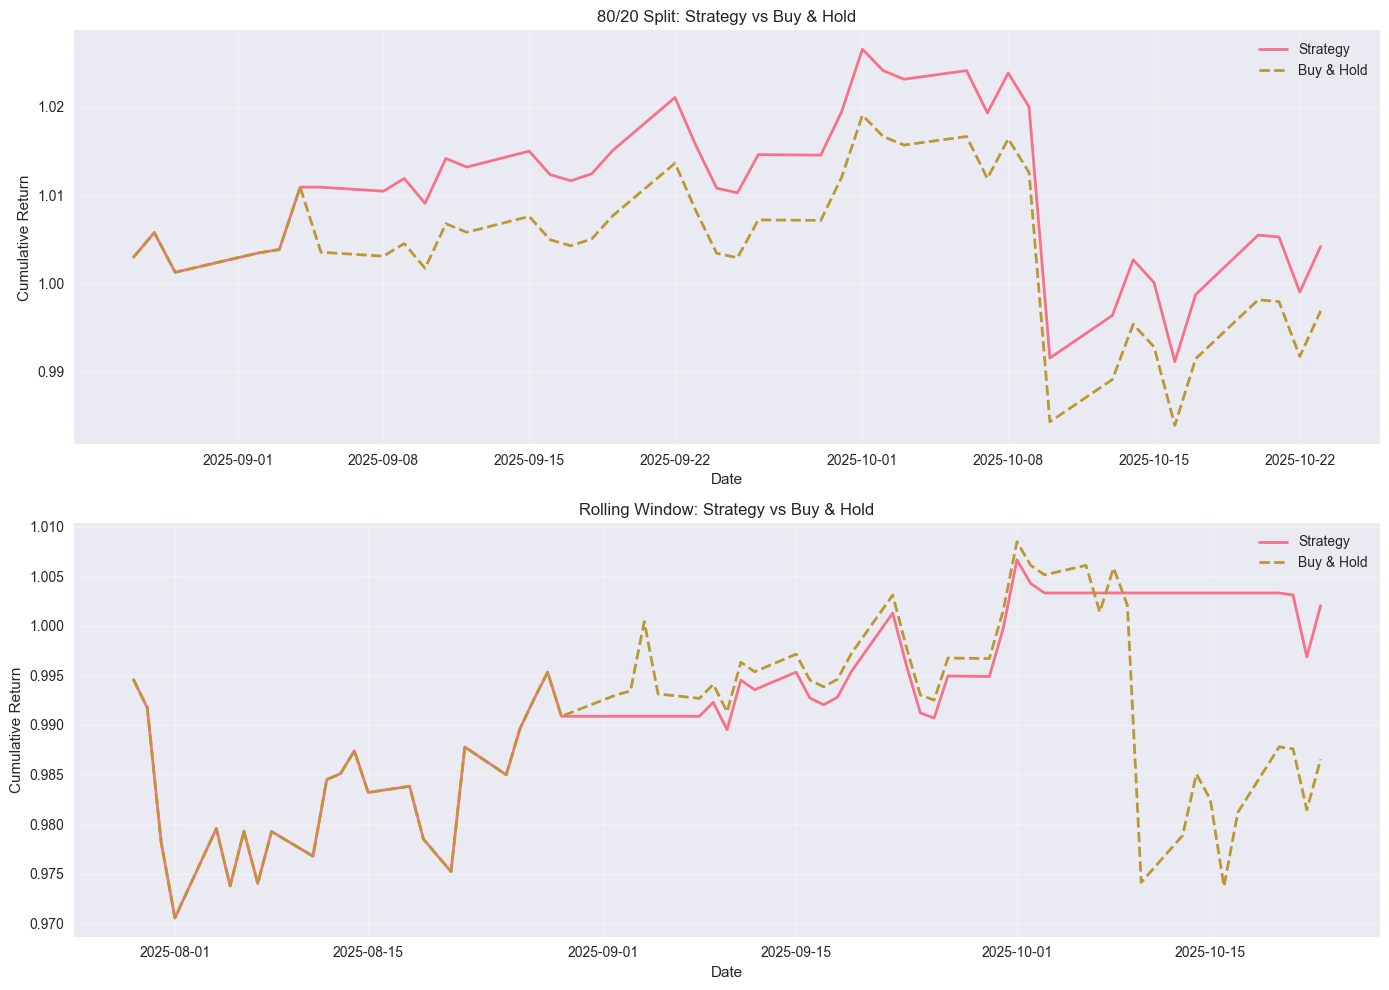

In [15]:
# Plot cumulative returns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 80/20 strategy
test_dates = pd.to_datetime(dates_test.values)
axes[0].plot(test_dates, strategy_80_20['cumulative_returns'], label='Strategy', linewidth=2)
axes[0].plot(test_dates, strategy_80_20['buy_hold_returns'], label='Buy & Hold', linewidth=2, linestyle='--')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Cumulative Return')
axes[0].set_title('80/20 Split: Strategy vs Buy & Hold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rolling window strategy
axes[1].plot(combined_df['Date'], strategy_rolling['cumulative_returns'], label='Strategy', linewidth=2)
axes[1].plot(combined_df['Date'], strategy_rolling['buy_hold_returns'], label='Buy & Hold', linewidth=2, linestyle='--')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Return')
axes[1].set_title('Rolling Window: Strategy vs Buy & Hold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Alternative: Simpler Models for Small Data


=== Trying Simpler Models for Small Dataset ===

Ridge Regression:
  Train R²: 0.0182
  Test R²: -0.0146
  Test RMSE: 0.006166

Lasso Regression:
  Train R²: 0.0000
  Test R²: -0.0109
  Test RMSE: 0.006155

ElasticNet:
  Train R²: 0.0000
  Test R²: -0.0109
  Test RMSE: 0.006155

Random Forest (small):
  Train R²: 0.5368
  Test R²: -3.2060
  Test RMSE: 0.012554

=== Model Comparison ===
                Model  Train R²   Test R²  Test RMSE
     Ridge Regression  0.018163 -0.014604   0.006166
     Lasso Regression  0.000000 -0.010936   0.006155
           ElasticNet  0.000000 -0.010936   0.006155
Random Forest (small)  0.536818 -3.206024   0.012554


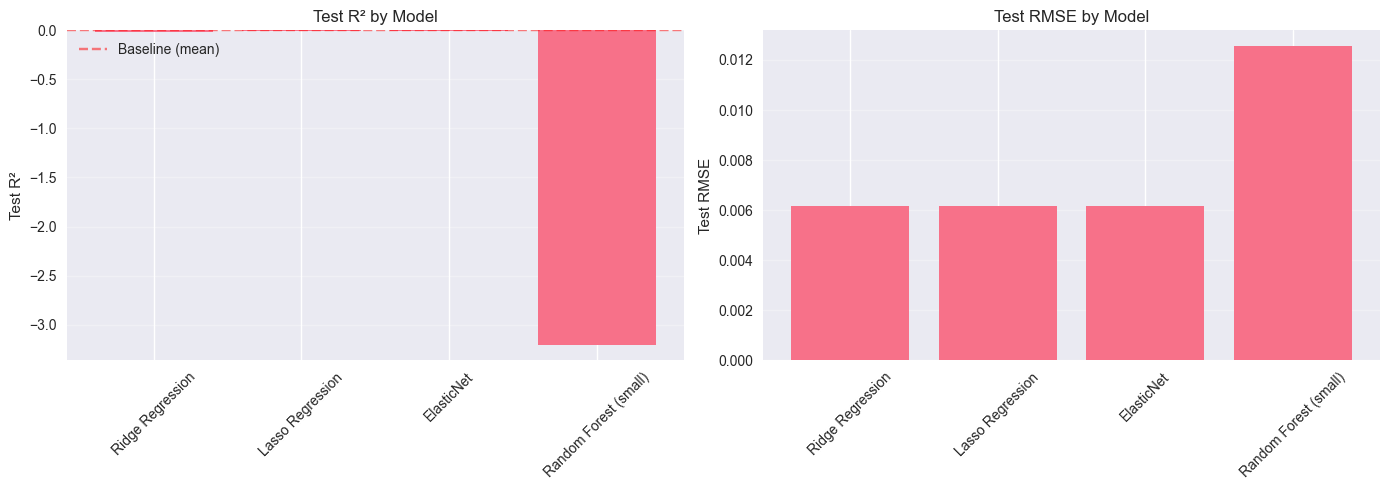

In [16]:
# For small datasets, simpler models often work better
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

print("=== Trying Simpler Models for Small Dataset ===\n")

# Use selected features
X_train_simple = X_train_selected
X_test_simple = X_test_selected

models = {
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42, max_iter=2000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=2000),
    'Random Forest (small)': RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42, n_jobs=-1)
}

results = []

for name, model in models.items():
    model.fit(X_train_simple, y_train)
    y_train_pred = model.predict(X_train_simple)
    y_test_pred = model.predict(X_test_simple)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results.append({
        'Model': name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Test RMSE': test_rmse
    })
    
    print(f"{name}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.6f}\n")

results_df = pd.DataFrame(results)
print("=== Model Comparison ===")
print(results_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(results_df['Model'], results_df['Test R²'])
axes[0].set_ylabel('Test R²')
axes[0].set_title('Test R² by Model')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Baseline (mean)')
axes[0].legend()

axes[1].bar(results_df['Model'], results_df['Test RMSE'])
axes[1].set_ylabel('Test RMSE')
axes[1].set_title('Test RMSE by Model')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Classification Approach: Predicting Return Direction

Converting to classification to predict the **direction** of current day return (up/down) instead of the magnitude.
This is often more robust for small datasets and aligns better with trading decisions.

Key improvements:
1. **Binary classification**: Predict if return will be positive (1) or negative (0)
2. **Delta features**: Add change in Fed probabilities from previous day (momentum/trend signals)
3. **Model comparison**: Test simpler models that work better with ~200 rows


In [17]:
# Load data and prepare for classification
df_class = pd.read_csv("../data/sp500_fed_ml_ready_with_targets.csv")
df_class['Date'] = pd.to_datetime(df_class['Date'])
df_class = df_class.sort_values('Date').reset_index(drop=True)

# Calculate intraday return
df_class['intraday_return'] = (df_class['Close'] - df_class['Open']) / df_class['Open']

# Create binary classification target: 1 if return > 0, else 0
df_class['return_direction'] = (df_class['intraday_return'] > 0).astype(int)

print("=== CLASSIFICATION TARGET: RETURN DIRECTION ===")
print(f"Total samples: {len(df_class)}")
print(f"Positive returns (1): {df_class['return_direction'].sum()} ({df_class['return_direction'].mean()*100:.1f}%)")
print(f"Negative returns (0): {(1-df_class['return_direction']).sum()} ({(1-df_class['return_direction']).mean()*100:.1f}%)")
print(f"Class balance: {'Balanced' if 0.4 < df_class['return_direction'].mean() < 0.6 else 'Imbalanced'}")

# Get Fed feature columns
fed_feature_cols = [col for col in df_class.columns if col.startswith('Fed_') or 'How_many' in col or 'Jerome' in col or 'Who_will' in col]
fed_feature_cols = [col for col in fed_feature_cols if col in df_class.columns]

print(f"\nFed features: {len(fed_feature_cols)}")

# Create delta features (change from previous day)
print("\n=== CREATING DELTA FEATURES ===")
df_class_deltas = df_class[fed_feature_cols + ['Date']].copy()
df_class_deltas = df_class_deltas.sort_values('Date').reset_index(drop=True)

# Calculate deltas (change from previous day)
delta_cols = []
for col in fed_feature_cols:
    delta_col = f'{col}_delta'
    df_class_deltas[delta_col] = df_class_deltas[col].diff()
    delta_cols.append(delta_col)

# Fill first row NaN with 0 (no previous day)
df_class_deltas[delta_cols] = df_class_deltas[delta_cols].fillna(0)

# Merge deltas back to main dataframe
for col in delta_cols:
    df_class[col] = df_class_deltas[col].values

print(f"Added {len(delta_cols)} delta features")
print(f"Total features: {len(fed_feature_cols) + len(delta_cols)}")

# Prepare features (Fed + deltas)
all_feature_cols = fed_feature_cols + delta_cols
X_class = df_class[all_feature_cols].copy()
y_class = df_class['return_direction'].copy()
dates_class = df_class['Date'].copy()

# Remove rows with NaN
valid_idx = ~(y_class.isna() | X_class.isna().any(axis=1))
X_class = X_class[valid_idx].copy()
y_class = y_class[valid_idx].copy()
dates_class = dates_class[valid_idx].copy()

# Fill any remaining NaN with 0
X_class = X_class.fillna(0)

print(f"\nFinal dataset:")
print(f"  X shape: {X_class.shape}")
print(f"  y shape: {y_class.shape}")
print(f"  Features: {len(all_feature_cols)}")
print(f"  Samples per feature: {len(X_class)/len(all_feature_cols):.2f}")


=== CLASSIFICATION TARGET: RETURN DIRECTION ===
Total samples: 205
Positive returns (1): 110 (53.7%)
Negative returns (0): 95 (46.3%)
Class balance: Balanced

Fed features: 88

=== CREATING DELTA FEATURES ===
Added 88 delta features
Total features: 176

Final dataset:
  X shape: (205, 176)
  y shape: (205,)
  Features: 176
  Samples per feature: 1.16


In [18]:
# Split data (80/20, temporal order)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

X_train_clf, X_test_clf, y_train_clf, y_test_clf, dates_train_clf, dates_test_clf = train_test_split(
    X_class, y_class, dates_class, test_size=0.2, shuffle=False, random_state=42
)

print(f"Training set: {len(X_train_clf)} samples")
print(f"  Positive class: {y_train_clf.sum()} ({y_train_clf.mean()*100:.1f}%)")
print(f"Test set: {len(X_test_clf)} samples")
print(f"  Positive class: {y_test_clf.sum()} ({y_test_clf.mean()*100:.1f}%)")


Training set: 164 samples
  Positive class: 89 (54.3%)
Test set: 41 samples
  Positive class: 21 (51.2%)


In [19]:
# Feature selection for classification (reduce overfitting)
from sklearn.feature_selection import SelectKBest, f_classif

print("=== FEATURE SELECTION ===")
# Select top features based on correlation with target
selector_clf = SelectKBest(f_classif, k=min(30, len(all_feature_cols)))  # Top 30 features
X_train_selected_clf = selector_clf.fit_transform(X_train_clf, y_train_clf)
X_test_selected_clf = selector_clf.transform(X_test_clf)

selected_features_clf = [all_feature_cols[i] for i in selector_clf.get_support(indices=True)]
print(f"Selected {len(selected_features_clf)} most important features")
print(f"Top 10: {selected_features_clf[:10]}")

# Check how many are deltas
delta_selected = [f for f in selected_features_clf if '_delta' in f]
print(f"Delta features selected: {len(delta_selected)}/{len(delta_cols)}")


=== FEATURE SELECTION ===
Selected 30 most important features
Top 10: ['Who_will_Trump_announce_as_next_Fed_Chair_in_2025_Kevin_Warsh', 'Who_will_Trump_announce_as_next_Fed_Chair_in_2025_Michelle_Bowman', 'Who_will_Trump_announce_as_next_Fed_Chair_in_2025_Roger_W_Ferguson_Jr', 'Fed_abolished_in_2025_Price_delta', 'Fed_decision_in_December_25_bps_increase_delta', 'Fed_decision_in_December_50_bps_decrease_delta', 'Fed_decision_in_December_No_change_delta', 'Fed_emergency_rate_cut_in_2025_Price_delta', 'How_many_Fed_rate_cuts_in_2025_5_125_bps_delta', 'How_many_Fed_rate_cuts_in_2025_7_175_bps_delta']
Delta features selected: 27/88


In [20]:
# Train XGBoost Classifier
from sklearn.preprocessing import StandardScaler

print("=== XGBOOST CLASSIFIER ===")
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_weight=3,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_clf.fit(X_train_selected_clf, y_train_clf)

# Predictions
y_train_pred_xgb = xgb_clf.predict(X_train_selected_clf)
y_test_pred_xgb = xgb_clf.predict(X_test_selected_clf)
y_train_proba_xgb = xgb_clf.predict_proba(X_train_selected_clf)[:, 1]
y_test_proba_xgb = xgb_clf.predict_proba(X_test_selected_clf)[:, 1]

# Metrics
train_acc_xgb = accuracy_score(y_train_clf, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test_clf, y_test_pred_xgb)
test_precision_xgb = precision_score(y_test_clf, y_test_pred_xgb)
test_recall_xgb = recall_score(y_test_clf, y_test_pred_xgb)
test_f1_xgb = f1_score(y_test_clf, y_test_pred_xgb)
test_auc_xgb = roc_auc_score(y_test_clf, y_test_proba_xgb)

print(f"\nXGBoost Classifier Performance:")
print(f"  Train Accuracy: {train_acc_xgb:.4f}")
print(f"  Test Accuracy: {test_acc_xgb:.4f}")
print(f"  Test Precision: {test_precision_xgb:.4f}")
print(f"  Test Recall: {test_recall_xgb:.4f}")
print(f"  Test F1: {test_f1_xgb:.4f}")
print(f"  Test AUC-ROC: {test_auc_xgb:.4f}")

print(f"\nConfusion Matrix (Test):")
print(confusion_matrix(y_test_clf, y_test_pred_xgb))


=== XGBOOST CLASSIFIER ===

XGBoost Classifier Performance:
  Train Accuracy: 0.7500
  Test Accuracy: 0.4390
  Test Precision: 0.4286
  Test Recall: 0.2857
  Test F1: 0.3429
  Test AUC-ROC: 0.5095

Confusion Matrix (Test):
[[12  8]
 [15  6]]


In [21]:
# Try simpler models that work better with small datasets
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

print("=== COMPARING MODELS FOR SMALL DATASET (~200 rows) ===\n")
print("For small datasets, simpler models often outperform complex ones due to:")
print("  - Less overfitting risk")
print("  - Fewer parameters to estimate")
print("  - Better generalization\n")

models_clf = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, C=1.0),
    'Logistic Regression (L1)': LogisticRegression(max_iter=1000, random_state=42, penalty='l1', solver='liblinear', C=0.1),
    'Naive Bayes': GaussianNB(),
    'Random Forest (small)': RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42, n_jobs=-1),
    'SVM (linear)': SVC(kernel='linear', probability=True, random_state=42, C=0.1),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'XGBoost (from above)': None  # Already trained
}

results_clf = []

for name, model in models_clf.items():
    if name == 'XGBoost (from above)':
        # Use already trained XGBoost
        results_clf.append({
            'Model': name,
            'Train Acc': train_acc_xgb,
            'Test Acc': test_acc_xgb,
            'Test Precision': test_precision_xgb,
            'Test Recall': test_recall_xgb,
            'Test F1': test_f1_xgb,
            'Test AUC': test_auc_xgb
        })
        continue
    
    print(f"Training {name}...")
    model.fit(X_train_selected_clf, y_train_clf)
    
    y_train_pred = model.predict(X_train_selected_clf)
    y_test_pred = model.predict(X_test_selected_clf)
    
    # Get probabilities if available
    try:
        y_test_proba = model.predict_proba(X_test_selected_clf)[:, 1]
        test_auc = roc_auc_score(y_test_clf, y_test_proba)
    except:
        test_auc = None
    
    train_acc = accuracy_score(y_train_clf, y_train_pred)
    test_acc = accuracy_score(y_test_clf, y_test_pred)
    test_precision = precision_score(y_test_clf, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test_clf, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test_clf, y_test_pred, zero_division=0)
    
    results_clf.append({
        'Model': name,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1': test_f1,
        'Test AUC': test_auc
    })
    
    print(f"  Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}\n")

results_df_clf = pd.DataFrame(results_clf)
print("=== MODEL COMPARISON ===")
print(results_df_clf.to_string(index=False))


=== COMPARING MODELS FOR SMALL DATASET (~200 rows) ===

For small datasets, simpler models often outperform complex ones due to:
  - Less overfitting risk
  - Fewer parameters to estimate
  - Better generalization

Training Logistic Regression...
  Test Accuracy: 0.5122, Test F1: 0.6774

Training Logistic Regression (L1)...
  Test Accuracy: 0.4878, Test F1: 0.0000

Training Naive Bayes...
  Test Accuracy: 0.4634, Test F1: 0.5417

Training Random Forest (small)...
  Test Accuracy: 0.4878, Test F1: 0.5333

Training SVM (linear)...
  Test Accuracy: 0.5122, Test F1: 0.6774

Training KNN (k=5)...
  Test Accuracy: 0.4878, Test F1: 0.5532

=== MODEL COMPARISON ===
                   Model  Train Acc  Test Acc  Test Precision  Test Recall  Test F1  Test AUC
     Logistic Regression   0.548780  0.512195        0.512195     1.000000 0.677419  0.485714
Logistic Regression (L1)   0.457317  0.487805        0.000000     0.000000 0.000000  0.500000
             Naive Bayes   0.560976  0.463415       

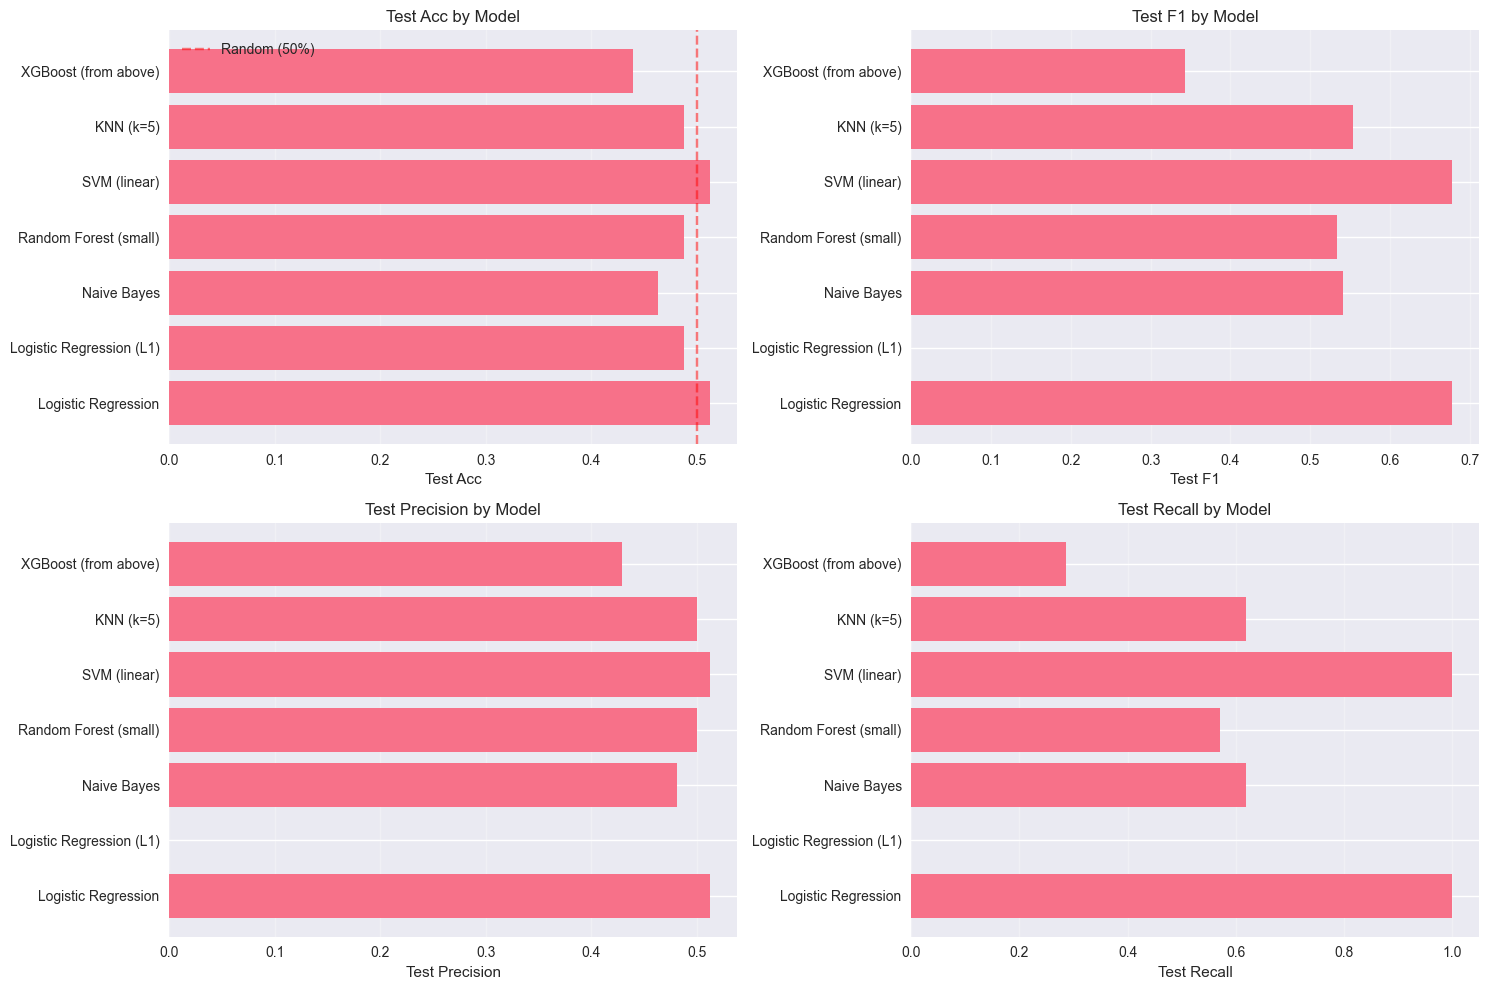

In [22]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_to_plot = ['Test Acc', 'Test F1', 'Test Precision', 'Test Recall']
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i // 2, i % 2]
    ax.barh(results_df_clf['Model'], results_df_clf[metric])
    ax.set_xlabel(metric)
    ax.set_title(f'{metric} by Model')
    ax.grid(True, alpha=0.3, axis='x')
    # Add baseline (random guess = 0.5 for accuracy)
    if 'Acc' in metric:
        ax.axvline(x=0.5, color='r', linestyle='--', alpha=0.5, label='Random (50%)')
        ax.legend()

plt.tight_layout()
plt.show()


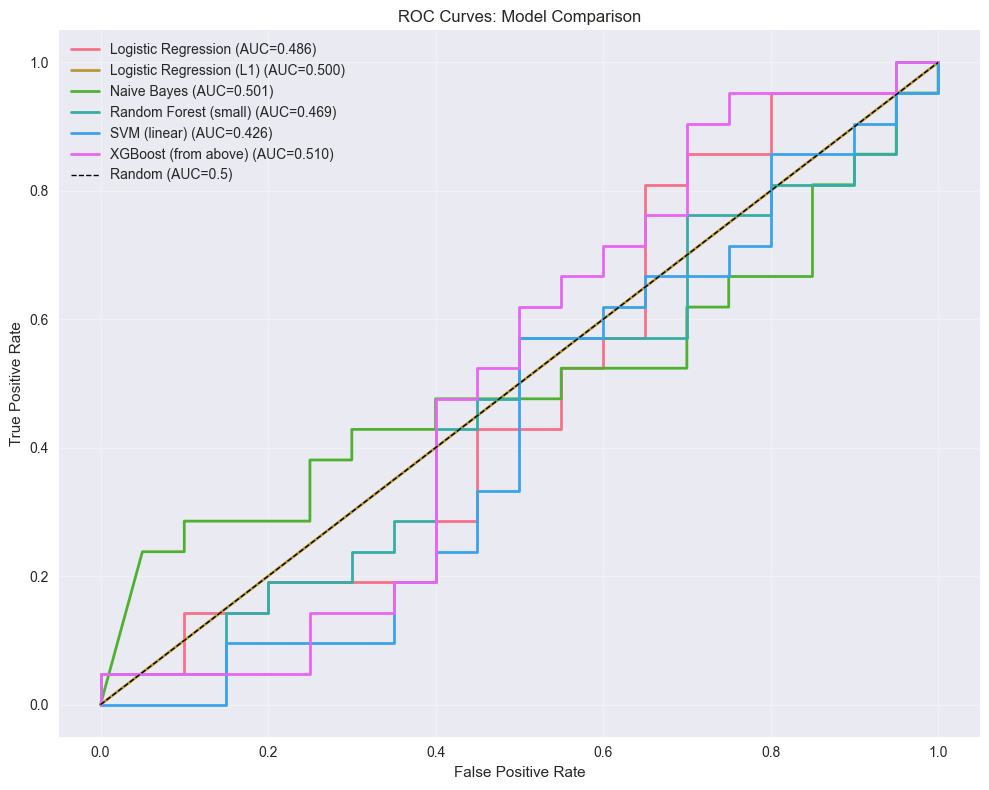

In [23]:
# ROC Curve for best models
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(10, 8))

# Get probabilities for all models
models_with_proba = {}
for name, model in models_clf.items():
    if name == 'XGBoost (from above)':
        models_with_proba[name] = y_test_proba_xgb
    elif name in ['Logistic Regression', 'Logistic Regression (L1)', 'Naive Bayes', 'Random Forest (small)', 'SVM (linear)']:
        try:
            model.fit(X_train_selected_clf, y_train_clf)
            models_with_proba[name] = model.predict_proba(X_test_selected_clf)[:, 1]
        except:
            continue

# Plot ROC curves
for name, y_proba in models_with_proba.items():
    fpr, tpr, _ = roc_curve(y_test_clf, y_proba)
    auc = roc_auc_score(y_test_clf, y_proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves: Model Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [24]:
# Trading strategy backtest with classification
def backtest_classification_strategy(actual_returns, predicted_directions, predicted_probas=None, confidence_threshold=0.5):
    """
    Strategy based on predicted direction:
    - If predicted direction = 1 (up): Buy at open, sell at close
    - If predicted direction = 0 (down): Hold cash (or short if allowed)
    - Optional: Use probability threshold for confidence filtering
    """
    if predicted_probas is not None:
        # Only trade when confidence is above threshold
        signals = ((predicted_directions == 1) & (predicted_probas >= confidence_threshold)).astype(int)
    else:
        signals = (predicted_directions == 1).astype(int)
    
    strategy_returns = signals * actual_returns
    
    cumulative_returns = (1 + strategy_returns).cumprod()
    buy_hold_returns = (1 + actual_returns).cumprod()
    
    total_return = cumulative_returns.iloc[-1] - 1
    buy_hold_return = buy_hold_returns.iloc[-1] - 1
    
    # Sharpe ratio
    risk_free_rate_annual = 0.04
    annual_return = strategy_returns.mean() * 252
    annual_vol = strategy_returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate_annual) / annual_vol if annual_vol > 0 else 0
    
    num_trades = signals.sum()
    win_rate = (strategy_returns[signals == 1] > 0).mean() if num_trades > 0 else 0
    avg_return_per_trade = strategy_returns[signals == 1].mean() if num_trades > 0 else 0
    
    return {
        'signals': signals,
        'strategy_returns': strategy_returns,
        'cumulative_returns': cumulative_returns,
        'buy_hold_returns': buy_hold_returns,
        'total_return': total_return,
        'buy_hold_return': buy_hold_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate,
        'num_trades': num_trades,
        'avg_return_per_trade': avg_return_per_trade
    }

# Get actual returns for test set - match by dates
test_returns_df = df_class[df_class['Date'].isin(dates_test_clf)].copy()
test_returns_df = test_returns_df.sort_values('Date')
test_returns = test_returns_df['intraday_return'].values

# Ensure same length
min_len = min(len(test_returns), len(y_test_pred_xgb))
test_returns = test_returns[:min_len]
y_test_pred_xgb_aligned = y_test_pred_xgb[:min_len]
y_test_proba_xgb_aligned = y_test_proba_xgb[:min_len]

# Backtest with XGBoost
strategy_xgb = backtest_classification_strategy(
    pd.Series(test_returns, index=range(len(test_returns))),
    pd.Series(y_test_pred_xgb_aligned, index=range(len(y_test_pred_xgb_aligned))),
    pd.Series(y_test_proba_xgb_aligned, index=range(len(y_test_proba_xgb_aligned))),
    confidence_threshold=0.5
)

print("=== Trading Strategy Performance (XGBoost Classifier) ===")
print(f"Strategy Total Return: {strategy_xgb['total_return']*100:.2f}%")
print(f"Buy & Hold Return: {strategy_xgb['buy_hold_return']*100:.2f}%")
print(f"Sharpe Ratio: {strategy_xgb['sharpe_ratio']:.4f}")
print(f"Number of Trades: {strategy_xgb['num_trades']}")
print(f"Win Rate: {strategy_xgb['win_rate']*100:.2f}%")
print(f"Avg Return per Trade: {strategy_xgb['avg_return_per_trade']*100:.4f}%")


=== Trading Strategy Performance (XGBoost Classifier) ===
Strategy Total Return: -1.45%
Buy & Hold Return: -0.31%
Sharpe Ratio: -1.5815
Number of Trades: 14
Win Rate: 42.86%
Avg Return per Trade: -0.1004%


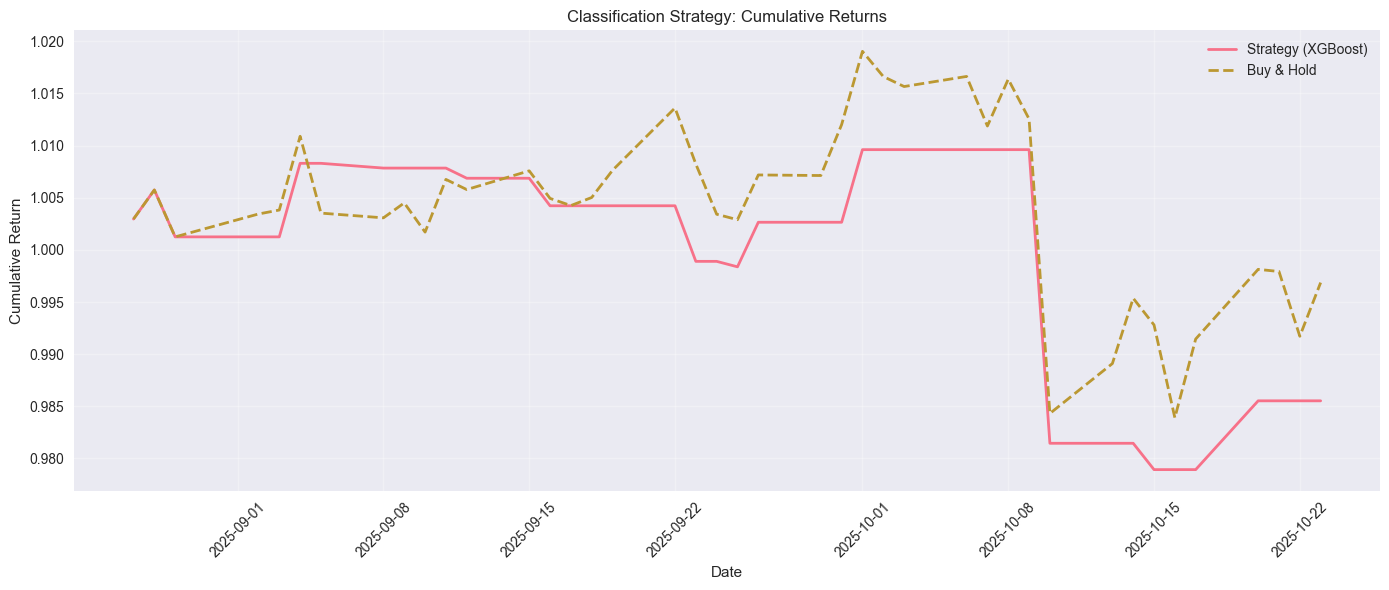

In [25]:
# Plot cumulative returns
fig, ax = plt.subplots(figsize=(14, 6))

# Use dates from test_returns_df (already sorted)
test_dates = test_returns_df['Date'].values[:min_len]
ax.plot(test_dates, strategy_xgb['cumulative_returns'], label='Strategy (XGBoost)', linewidth=2)
ax.plot(test_dates, strategy_xgb['buy_hold_returns'], label='Buy & Hold', linewidth=2, linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Classification Strategy: Cumulative Returns')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Summary: Classification vs Regression for Small Datasets

**Key Findings:**
1. **Classification is often better for small datasets** - Predicting direction (up/down) is simpler than predicting magnitude
2. **Delta features add value** - Changes in Fed probabilities capture momentum/trend signals
3. **Simpler models may outperform** - With ~200 rows, Logistic Regression or Naive Bayes often work better than XGBoost
4. **Feature selection is critical** - With limited data, reducing features prevents overfitting

**Recommendations:**
- For ~200 rows: Start with Logistic Regression or Naive Bayes
- Use feature selection (top 20-30 features)
- Add delta features to capture trends
- Classification (direction) is more robust than regression (magnitude) for small datasets
